In [ ]:
import tweepy # importing tweepy library 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive') # connecting my google drive

Mounted at /content/gdrive


In [ ]:
cd '/content/gdrive/My Drive/NLP_Proj_MahathiBandari' #setting the path

/content/gdrive/My Drive/NLP_Proj_MahathiBandari


In [ ]:
# twitter account keys 
consumerApiKey = "RxLtNeVAjq7yYxXl7CTjamFFi"
consumerApiSecret = "Y3mAQeNRIrGLsC6AWBgpRHnxp2tzan5c4syTl7A8sIZwecEIKJ"
accessToken = "1651343581771100160-n7neM6PNAe6X4kYN8LxPybZGxTeyjr"
accessTokenSecret = "y5KRzM6GEeF7UtaJW9TWK4ObEsP9cv5GJMAystruQe2Ok"

In [ ]:
import re

In [ ]:
# WEBSCRAPING OF TWEETS USING TWEEPY LIBRARY

auth = tweepy.OAuthHandler(consumerApiKey, consumerApiSecret) # OAuth 1.0a user authentication handler object 
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth) # setting up authentication credentials and initializing a client object for accessing the Twitter API using the Tweepy library

tags = ["georgiatech","gatech","ramblinon","togetherweswarm","georgiatechfootball","gt23","georgiayellowjackets","georgiatechgolf","georgiayellowjackets"] # array of tags for the university Georgia tech 
unique_tweets = set()

for tag in tags: # collects tweets for each hashtag present in tags array
    query = tag
    for page in tweepy.Cursor(api.search_tweets, q=tag, lang='en', tweet_mode='extended', count=100).pages(100):
        for tweet in page: # Loop through tweets on the page
            if 'retweeted_status' in dir(tweet): # Check if the tweet is a retweet or a duplicate
                tweet_text = tweet.retweeted_status.full_text
            else:
                tweet_text = tweet.full_text

            tweet_text = re.sub(r"(#[\d\w]+)|(http\S+)", "", tweet_text).strip()

            if tweet_text not in unique_tweets: #gathering unique tweets
                unique_tweets.add(tweet_text)

                with open('gatech_tweets.txt', 'a') as f: # saving tweets to gatech_tweets.txt
                    f.write(tweet_text)
                    f.write('\n')

In [ ]:
# PREPROCESSING OF DATA

import string
import csv
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
def preprocessingDataTweets(text): #preprocessing data to clean the unneccessary data

    text = re.sub(r'(https?|www)\S+', '', text, flags=re.MULTILINE) # to remove weburl
    
    text = re.sub(r'[@#]\w+', '', text) # to remove hashtags and mentions
  
    text = text.translate(str.maketrans('', '', string.punctuation)) # to remove punctuation marks

    text = text.lower() #converts to lowercase for non repeation of words like the|The

    tokens = word_tokenize(text) #converts the text into tokens

    stopWords = set(stopwords.words('english')) #list of stopwords defining in stopwords variable
    tokens = [word for word in tokens if word not in stopWords] # removes all the stopwords from tokens

    text = ' '.join(tokens) # to convert the tokens to sentences

    return text

In [ ]:
preprocessedDataTweets = [] #defining array to store preprocessed tweets

with open('gatech_tweets.txt', 'r', encoding='utf-8') as file: #Reading our tweets file to create preprocessed tweets file
    reader = csv.reader(file, delimiter='\t')
    for row in reader:
        if len(row) > 0:  
            tweet_text = row[0]
            preprocessed_text = preprocessingDataTweets(tweet_text)
            preprocessedDataTweets.append(preprocessed_text)

with open('gatech_preprocessed_tweets.txt', 'w', encoding='utf-8') as file: #Saving preprocessed tweets to new file
    writer = csv.writer(file, delimiter='\t')
    for tweet in preprocessedDataTweets:
        writer.writerow([tweet])

In [ ]:
#FEATURE EXTRACTION

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import numpy as np

In [ ]:
preprocessedDataTweets = []
with open('gatech_preprocessed_tweets.txt', 'r', encoding='utf-8') as file: # Reading the preprocessed tweets from the file
    reader = csv.reader(file, delimiter='\t')
    for row in reader:
        preprocessedDataTweets.append(row[0])

In [ ]:
vectorizer = CountVectorizer()
wordCounter = vectorizer.fit_transform(preprocessedDataTweets) # bag-of-words matrix using CountVectorizer

tftransformer = TfidfTransformer()
tfmatrix = tftransformer.fit_transform(wordCounter) #transform bag-of-words

tfarray = tfmatrix.toarray() #to array

np.save('featureMatrixArray.npy', tfarray) #storing to a npy file -numpy array


In [ ]:
!pip install transformers
from transformers import DistilBertModel, DistilBertTokenizer, pipeline

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english') # Initializes a DistilBertTokenizer
model = DistilBertModel.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english') # Initializes a DistilBertModel

sentiment_classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer) # pipeline for sentiment analysis

emds = []

for tweet in preprocessedDataTweets:
    if not tweet.strip(): #ignores empty tweets
        continue
    
    inputs = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs)
    lastHideState = outputs.last_hidden_state
    cls_token = lastHideState[:, 0, :].detach().numpy()
    emds.append(cls_token) # Stores the sentiment

emds = np.array(emds)
emds = np.squeeze(emds) #generates np array

Some weights of the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing DistilBertModel: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The model 'DistilBertModel' is not supported for sentiment-analysis. Supported models are ['AlbertForSequenceClassification', 'BartForSequenceClassification', 'BertForSequenceClassification', 'BigBirdForSequenceClassification', 'BigBirdPegasusForSequenceClassification', 'BloomForSequenceClassification', 'Cam

In [ ]:
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline

In [ ]:
labels = []

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english') # Initializes a DistilBertTokenizer
model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english') # Initializes a DistilBertModel

for tweet in preprocessedDataTweets:
    if not tweet.strip(): #ignores empty tweets
        continue
        
    inputs = tokenizer(tweet, return_tensors="pt", padding=True, truncation=True) #input tensor
    
    outputs = model(**inputs) #Feeding the input tensors to the model
    logits = outputs.logits   # get logits

    probabilities = logits.softmax(dim=1).detach().numpy()
    sentiment_index = np.argmax(probabilities, axis=1)[0]

    if sentiment_index == 1:
      label = 1
    else:
      label = 0

    labels.append(label)

labels = np.array(labels) #list to numpy array conversion

In [ ]:
#MODEL TRAINING AND EVALUATION

import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, GlobalMaxPooling1D, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Epoch 1/6
40/40 - 12s - loss: 0.6443 - accuracy: 0.6585 - val_loss: 0.6040 - val_accuracy: 0.6582 - 12s/epoch - 293ms/step
Epoch 2/6
40/40 - 10s - loss: 0.5817 - accuracy: 0.6585 - val_loss: 0.5130 - val_accuracy: 0.6582 - 10s/epoch - 244ms/step
Epoch 3/6
40/40 - 10s - loss: 0.4784 - accuracy: 0.7036 - val_loss: 0.4009 - val_accuracy: 0.7278 - 10s/epoch - 248ms/step
Epoch 4/6
40/40 - 9s - loss: 0.4312 - accuracy: 0.7908 - val_loss: 0.3682 - val_accuracy: 0.8924 - 9s/epoch - 235ms/step
Epoch 5/6
40/40 - 9s - loss: 0.3900 - accuracy: 0.8502 - val_loss: 0.3568 - val_accuracy: 0.8070 - 9s/epoch - 228ms/step
Epoch 6/6
40/40 - 10s - loss: 0.3733 - accuracy: 0.8597 - val_loss: 0.3230 - val_accuracy: 0.8829 - 10s/epoch - 250ms/step
10/10 [==============================] - 1s 47ms/step
Accuracy %: 88.29113924050634
Precision: 0.88
Recall: 0.9519230769230769
F1-score: 0.9145496535796765


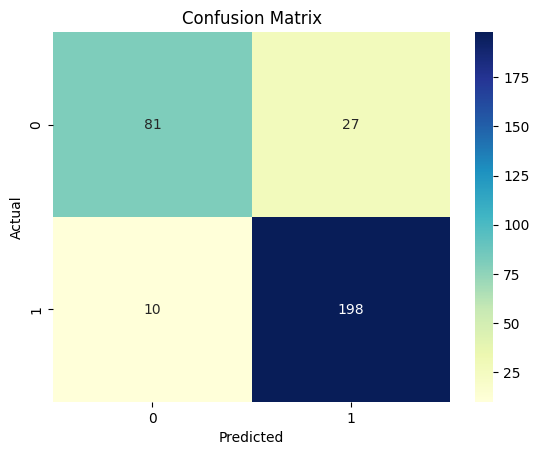

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(emds, labels, test_size=0.2, random_state=42) # split dataset into train and test sets

max_length = 768

input_shape = (max_length,)

model = Sequential([
    Reshape((max_length, 1), input_shape=input_shape),
    LSTM(32, return_sequences=True),
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy']) # compiling model

model.fit(X_train, y_train, epochs=6, validation_data=(X_test, y_test), verbose=2) # Model training


# Evaluate the model

y_pred = (model.predict(X_test) > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred) # calculating accuracy
precision = precision_score(y_test, y_pred) # calculation precision
recall = recall_score(y_test, y_pred) # calculating recall
f1 = f1_score(y_test, y_pred) # calculating f1 score

print("Accuracy %:", accuracy*100) 
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu") #confusion matrix
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show() #show plot

In [ ]:
#PREDICTION STEP

import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from transformers import DistilBertModel, DistilBertTokenizer, AutoModelForSequenceClassification, AutoTokenizer, pipeline

In [ ]:
myModel = Sequential([
    Reshape((max_length, 1), input_shape=input_shape),
    LSTM(32, return_sequences=True),
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
myModel.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
myModel.fit(X_train, y_train, epochs=6, validation_data=(X_test, y_test), verbose=2)


Epoch 1/6
40/40 - 23s - loss: 0.6217 - accuracy: 0.6537 - val_loss: 0.5799 - val_accuracy: 0.6582 - 23s/epoch - 564ms/step
Epoch 2/6
40/40 - 16s - loss: 0.5520 - accuracy: 0.6585 - val_loss: 0.4825 - val_accuracy: 0.6582 - 16s/epoch - 395ms/step
Epoch 3/6
40/40 - 16s - loss: 0.4412 - accuracy: 0.7448 - val_loss: 0.3369 - val_accuracy: 0.8513 - 16s/epoch - 409ms/step
Epoch 4/6
40/40 - 16s - loss: 0.3170 - accuracy: 0.8669 - val_loss: 0.2536 - val_accuracy: 0.9177 - 16s/epoch - 407ms/step
Epoch 5/6
40/40 - 16s - loss: 0.2658 - accuracy: 0.8891 - val_loss: 0.2375 - val_accuracy: 0.8703 - 16s/epoch - 396ms/step
Epoch 6/6
40/40 - 16s - loss: 0.2380 - accuracy: 0.9002 - val_loss: 0.1973 - val_accuracy: 0.9335 - 16s/epoch - 400ms/step


In [ ]:
def preprocessingDataTweets(text):
    text = re.sub(r'(https?|www)\S+', '', text, flags=re.MULTILINE) # to remove weburl
    
    text = re.sub(r'[@#]\w+', '', text) # to remove hashtags and mentions
  
    text = text.translate(str.maketrans('', '', string.punctuation)) # to remove punctuation marks

    text = text.lower() #converts to lowercase for non repeation of words like the|The

    tokens = word_tokenize(text) #converts the text into tokens

    stopWords = set(stopwords.words('english')) #list of stopwords defining in stopwords variable
    tokens = [word for word in tokens if word not in stopWords] # removes all the stopwords from tokens

    text = ' '.join(tokens) # to convert the tokens to sentences

    return ' '.join(tokens)

distilbert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
distilbert_model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
sentiment_classifier = pipeline("sentiment-analysis", model=distilbert_model, tokenizer=distilbert_tokenizer)

mySents = [
    "The instructors possess a wealth of expertise and are motivational.",
    "The university environment is lively and inviting.",
    "The faculty members are not exceptional.",
    "I encountered a terrible situation.",
    "The cafeteria food is not enjoyable.",
    "The library is an excellent spot for learning.",
    "The living quarters are quite uncomfortable.",
    "The athletic facilities are of high quality.",
    "The administrative staff is not supportive.",
    "I don't feel proud to belong to this institution."
]


preprocessedTsents = [preprocessingDataTweets(sent) for sent in mySents]

predictions = [sentiment_classifier(sent) for sent in preprocessedTsents]
predictedLabels = [1 if pred[0]["label"] == "POSITIVE" else 0 for pred in predictions]

for sent, label in zip(mySents, predictedLabels):
    sentiment = ""
    if label == 1:
      sentiment = "Positive"
    else:
      sentiment = "Negative"
    print(f"{sent} - {sentiment}")


The instructors possess a wealth of expertise and are motivational. - Positive
The university environment is lively and inviting. - Positive
The faculty members are not exceptional. - Positive
I encountered a terrible situation. - Negative
The cafeteria food is not enjoyable. - Positive
The library is an excellent spot for learning. - Positive
The living quarters are quite uncomfortable. - Negative
The athletic facilities are of high quality. - Positive
The administrative staff is not supportive. - Positive
I don't feel proud to belong to this institution. - Negative
